In [1]:
import matplotlib.pyplot as plt
import os,glob,imp
import numpy as np
import seaborn as sns
import pyslha, copy, pickle
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts


def getCurve(slhaFolder,effFolder,rcurves = [1.0]):
    
    
    #Get efficiencies:
    rValues = []
    pts = []
    errors= []
    for f in glob.glob(os.path.join(effFolder,'*.py')):
        with open(f, 'rb') as fp: ## imports file with dots in name
            output_module = imp.load_module("smodelsOutput",fp,f,('.py', 'rb', imp.PY_SOURCE))
            out = output_module.smodelsOutput
        slhadata = pyslha.readSLHAFile(os.path.join(slhaFolder,os.path.basename(f).replace('.py','')))
        y = slhadata.blocks['MASS'][1000021]
        if not 'ExptRes' in out:
            r = 0.0
        else:
            r = out['ExptRes'][0]['r']
        x = np.log10(1.9e-13/slhadata.decays[1000021].totalwidth)
        rValues.append([x,y,r])
    rValues = np.array(sorted(rValues))
    
    excCurve = []
    excCurve = getContour(rValues[:,0],rValues[:,1],rValues[:,2],levels=rcurves)

    return excCurve,rValues


def fill_between(curve1,curve2,smooth=False):
    """
    Plot shaded region between curve1 and curve 2
    """
    
    #First interpolate curves, so they can be both evaluated at the same x values:
    c1F  = interp1d(curve1[:,0],curve1[:,1],fill_value='extrapolate',bounds_error=False)
    c2F  = interp1d(curve2[:,0],curve2[:,1],fill_value='extrapolate',bounds_error=False)
    #Get all x values:
    x = [pt[0] for pt in curve1] + [pt[0] for pt in curve2]
    x = sorted(list(set(x)))
    
    #create new list of values with interpolation:
    y1 = np.array([c1F(xv) for xv in x])
    y2 = np.array([c2F(xv) for xv in x])
           
    return x,y1,y2
    

## Get curve

In [3]:
#Get SModelS curve:
excCurves,rValues = getCurve('./T2Disp_results/','./T2Disp_results/',rcurves=[0.8,1.0,1.2])

In [4]:
#Official curve
excCMS = np.genfromtxt('../orig/CMS-EXO-19-001_Figure_004.csv',delimiter=',',names=True)

## Plot Curves

/home/lessa/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


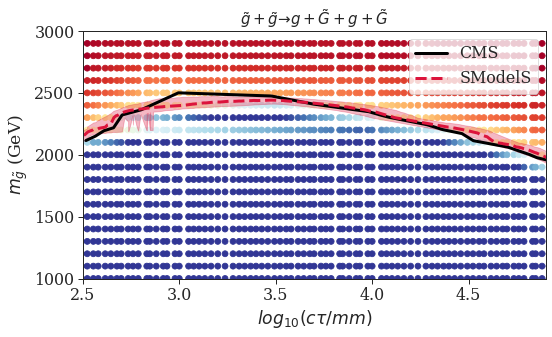

In [5]:
fig = plt.figure(figsize=(8,5))
plt.scatter(rValues[:,0],rValues[:,1],c=rValues[:,2],s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
plt.plot(excCMS['x'],excCMS['Curve1'],label='CMS',linewidth=3,linestyle='-',color='black')

# plt.plot(excCurves[1.2][0][:,0],excCurves[1.2][0][:,1],linewidth=3,linestyle='--',color='red')
plt.plot(excCurves[1.0][0][:,0],excCurves[1.0][0][:,1],linewidth=3,linestyle='--',color='crimson',label='SModelS')
x,y1,y2 = fill_between(excCurves[0.8][0],excCurves[1.2][0])
plt.fill_between(x,y2,y1,alpha=0.3,color='crimson')

plt.xlabel(r'$log_{10}\left(c \tau /mm\right)$')    
plt.ylabel(r'$m_{\tilde g}$ (GeV)')
plt.xlim(2.5,4.9)
plt.ylim(1000,3000.)
plt.title(r"$\tilde{g} + \tilde{g} \to g + \tilde{G} + g + \tilde{G}$",fontsize=15)
plt.tight_layout()
plt.savefig('validation_CMS-EXO-19-001.png')
plt.legend()
# plt.colorbar()
plt.show()